In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import csv
import time
import os, datetime
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.8.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Hyperparameters

In [3]:
batch_size = 64
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## Load Microsoft data

In [4]:
# df = pdr.get_data_tiingo("MSFT", api_key="aeeaa9dbc8f82f2c361abaa259050d75e736b424")

ticker = yf.Ticker("MSFT")
df = ticker.history(period="max")


df.to_csv("MSFT.csv")
df = pd.read_csv("MSFT.csv", delimiter=',', usecols=['Date', 'Close'])
df.sort_values('Date', inplace=True)
price_history = df
df = df["Close"]

prices = price_history[["Close"]].pct_change().dropna()

df

0         0.061252
1         0.063439
2         0.064533
3         0.062892
4         0.061799
           ...    
9098    280.519989
9099    285.299988
9100    286.359985
9101    280.809998
9102    277.559998
Name: Close, Length: 9103, dtype: float64

In [5]:
prices

,Close
1,0.035712
2,0.017250
3,-0.025432
4,-0.017390
5,-0.026547
...,...
9098,0.002466
9099,0.017040
9100,0.003715
9101,-0.019381


## Plot daily IBM closing prices and volume

In [6]:
# fig = plt.figure(figsize=(15,10))
# st = fig.suptitle("Microsoft Close Price and Volume", fontsize=20)
# st.set_y(0.92)

# ax1 = fig.add_subplot(211)
# ax1.plot(df['Close'], label='MS Close Price')
# ax1.set_xticks(range(0, df.shape[0], 1464))
# ax1.set_xticklabels(df['Date'].loc[::1464])
# ax1.set_ylabel('close Price', fontsize=18)
# ax1.legend(loc="upper left", fontsize=12)

# ax2 = fig.add_subplot(212)
# ax2.plot(df['Volume'], label='MS Volume')
# ax2.set_xticks(range(0, df.shape[0], 1464))
# ax2.set_xticklabels(df['Date'].loc[::1464])
# ax2.set_ylabel('volume', fontsize=18)
# ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [7]:
# '''Calculate percentage change'''

# df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
# df['High'] = df['High'].pct_change() # Create arithmetic returns column
# df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
# df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
# df['Volume'] = df['Volume'].pct_change()

# df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
last_30pct = sorted(df.index.values)[-int(0.3*len(times))] # Last 30% of series

# ###############################################################################
# '''Normalize price columns'''
# #
# min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
# max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# print(min_return)
# print(max_return)

In [8]:
# Min-max normalize price columns (0-1 range)
# df_temp = df[['Open','High','Low','Close']]
scaler_1 = MinMaxScaler(feature_range=(0, 1))
df = scaler_1.fit_transform(np.array(df).reshape(-1,1))
df
# df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
# df['High'] = (df['High'] - min_return) / (max_return - min_return)
# df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
# df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

array([[1.27790319e-05],
       [1.91685697e-05],
       [2.23651503e-05],
       ...,
       [8.36299636e-01],
       [8.20087961e-01],
       [8.10594618e-01]])

In [9]:
scaler_2 = MinMaxScaler()
df_prices = scaler_2.fit_transform(prices)
df_prices

array([[0.67806642],
       [0.6409055 ],
       [0.55499404],
       ...,
       [0.61366223],
       [0.56717267],
       [0.58288788]])

In [10]:
df = pd.DataFrame(df,columns=['Close'])
# scaler_2 = MinMaxScaler(feature_range=(0, 1))
# df['Volume'] = scaler_1.fit_transform(np.array(df['Volume']).reshape(-1, 1))
df.replace(0, np.nan, inplace=True)
df.dropna(how='any', axis=0, inplace=True)
# df.reset_index(inplace=True)
df

,Close
0,0.000013
1,0.000019
2,0.000022
3,0.000018
4,0.000014
...,...
9098,0.819241
9099,0.833203
9100,0.836300
9101,0.820088


In [11]:
df = pd.DataFrame(df_prices,columns=['Close'])
df

,Close
0,0.678066
1,0.640905
2,0.554994
3,0.571180
4,0.552749
...,...
9097,0.611147
9098,0.640482
9099,0.613662
9100,0.567173


In [12]:
###############################################################################
# '''Normalize volume column'''

# min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
# max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# # Min-max normalize volume columns (0-1 range)
# df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

# df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
# df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
# df_test = df[(df.index >= last_10pct)]

df_train = df[(df.index < last_30pct)]  # Training data are 70% of total data
df_val = df[(df.index >= last_30pct) & (df.index < last_20pct)]
df_test = df[(df.index >= last_20pct)]

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (6373, 1)
Validation data shape: (910, 1)
Test data shape: (1819, 1)


,Close
0,0.678066
1,0.640905
2,0.554994
3,0.571180
4,0.552749


## Plot daily changes of close prices and volume

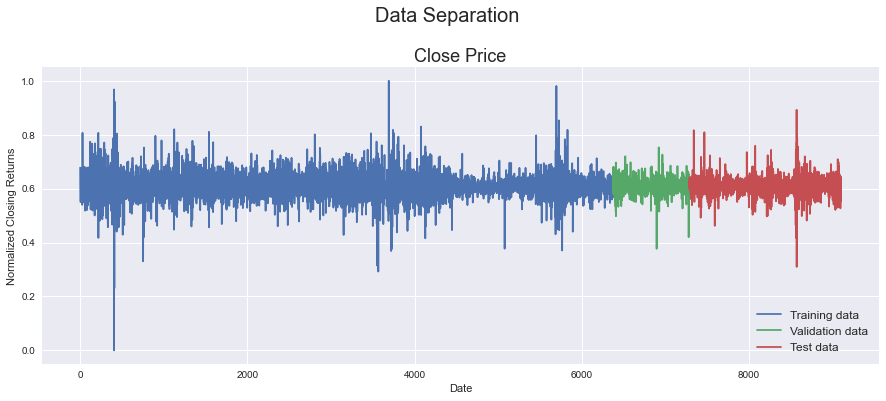

In [13]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train, label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val, label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test, label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

# ###############################################################################

# ax2 = fig.add_subplot(212)
# ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

# ax2.plot(np.arange(train_data.shape[0], 
#                    train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

# ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
#                    train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
# ax2.set_xlabel('Date')
# ax2.set_ylabel('Normalized Volume Changes')
# ax2.set_title("Volume", fontsize=18)
# ax2.legend(loc="best", fontsize=12)

In [14]:
def separate_data(dataset, time_step=1, predicting_steps_after=1):
    dataset = dataset.ravel()
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - predicting_steps_after + 1):
        a = dataset[i : (i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step + predicting_steps_after - 1])
    return np.array(dataX), np.array(dataY)

## Create chunks of training, validation and test data

In [15]:
# Training data
shift_num = 15


X_train, y_train = separate_data(train_data, seq_len, shift_num)
X_val, y_val = separate_data(val_data, seq_len, shift_num)
X_test, y_test = separate_data(test_data, seq_len, shift_num)


# X_train, y_train = [], []
# for i in range(seq_len, len(train_data)-shift_num):
#   X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_train.append(train_data[:, 0][i+shift_num]) #Value of 4th column (Close Price) of df-row 128+1
# X_train, y_train = np.array(X_train), np.array(y_train)


# # Validation data
# X_val, y_val = [], []
# for i in range(seq_len, len(val_data)-shift_num):
#     X_val.append(val_data[i-seq_len:i])
#     y_val.append(val_data[:, 0][i+shift_num])
# X_val, y_val = np.array(X_val), np.array(y_val)


# # Test data
# X_test, y_test = [], []
# for i in range(seq_len, len(test_data)-shift_num):
#     X_test.append(test_data[i-seq_len:i])
#     y_test.append(test_data[:, 0][i+shift_num])    
# X_test, y_test = np.array(X_test), np.array(y_test)


print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape', X_test.shape, y_test.shape)

Training set shape (6231, 128) (6231,)
Validation set shape (768, 128) (768,)
Testing set shape (1677, 128) (1677,)


In [16]:
train_data[:,0][seq_len]

0.6061837796654627

In [17]:
y_train

array([0.76650931, 0.64742713, 0.66276604, ..., 0.6282295 , 0.62798925,
       0.62360715])

In [18]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [19]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Model

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# model = models.Sequential()

# model.add(layers.LSTM(50, return_sequences=True, input_shape=(100, 1)))
# model.add(layers.LSTM(50, return_sequences=True))
# model.add(layers.LSTM(50))
# model.add(layers.Dense(1))

# # img_new = model.predict(x_test)

# model.compile(loss="mean_squared_error", optimizer="adam")

# model.fit(
#     X_train,
#     y_train,
#     validation_data=(X_val, y_val),
#     epochs=10,
#     batch_size=64,
#     verbose=1,
# )

# tf.debugging.set_log_device_placement(True)

# with tf.device("/gpu:0"):
model = models.Sequential()

model.add(layers.LSTM(50, return_sequences=True, input_shape=(seq_len, 1)))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.LSTM(50))
model.add(layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=2,
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 128, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
98/98 - 7s - loss: 0.0174 - val_loss

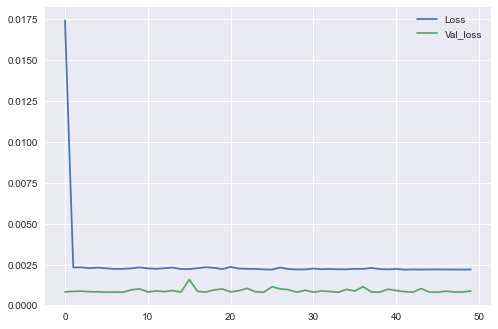

In [21]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Val_loss")
plt.legend()
plt.show()

## Accuracy

In [22]:
def MSE(y_actual, y_predicted):
    mse = np.mean((y_actual - y_predicted)**2)
    return mse

def MAE(y_actual, y_predicted):
    mae = np.mean(abs(y_actual - y_predicted))
    return mae

def MAPE(y_actual, y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

def RMSE(y_actual, y_predicted):
    rmse = np.sqrt(MSE(y_actual, y_predicted))
    return rmse

In [23]:
test_pred = model.predict(X_test)
mse = round(MSE(y_test, test_pred),5)
mae = round(MAE(y_test, test_pred),5)
mape = round(MAPE(y_test, test_pred),5)
rmse = round(RMSE(y_test, test_pred),5)
print("MSE: ",mse)
print("MAE: ",mae)
print("MAPE: ",mape)
print("RMSE: ",rmse)

MSE:  0.00128
MAE:  0.02492
MAPE:  4.08494
RMSE:  0.03578


## Store accuracy data

In [24]:
field_names = ["MSE", "MAE", "MAPE", "RMSE"]

In [25]:
new_row={'MSE':mse,'MAE': mae,'MAPE': mape,'RMSE':rmse}

In [26]:
file_route = 'Accuracy_data/LSTM.csv'

In [27]:
from csv import DictWriter

with open(file_route, 'a', encoding='UTF8') as f_object:
    
    dictwriter_object = DictWriter(f_object, fieldnames=field_names)

    dictwriter_object.writerow(new_row)
  
    f_object.close()

In [28]:
accuracy_data = pd.read_csv(file_route)
accuracy_data

,MSE,MAE,MAPE,RMSE
0,0.00123,0.02397,3.94729,0.03508
1,0.00121,0.02354,3.88811,0.03477
2,0.00122,0.02368,3.90741,0.03487
3,0.00118,0.02310,3.84390,0.03442
4,0.00121,0.02372,3.98125,0.03483
5,0.00137,0.02644,4.47895,0.03706
6,0.00122,0.02379,3.92170,0.03494
7,0.00120,0.02339,3.86878,0.03466
8,0.00122,0.02388,4.01183,0.03495
9,0.00154,0.02919,4.73709,0.03921


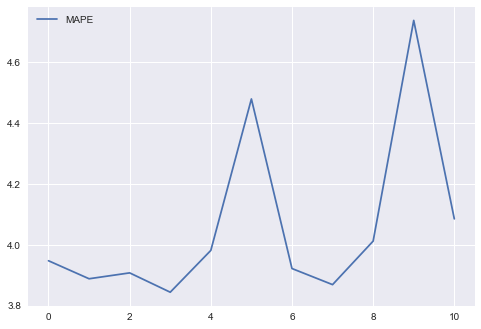

In [29]:
plt.plot(accuracy_data["MAPE"], label = "MAPE")
plt.legend()
plt.show()

## Other works

In [30]:
# y_test

In [31]:
# test_pred

In [32]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 0], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 0], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 0], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

 
Evaluation metrics


TypeError: 'float' object is not subscriptable

In [ ]:
def stock_predict(model, df_close, days):
    pred = model.predict(df_close)
    pred = scaler_1.inverse_transform(pred)
    return pred

In [ ]:
stock_predict(model,X_train,5)

In [ ]:
def stock_predict(model, df_close, scaler, days):
    # model = keras.models.load_model(model_path)

    train_size = int(len(df_close) * 0.8)
    close_test = df_close[train_size : len(df_close)]

    num_take = len(close_test) - 100
    x_input = close_test[num_take:].reshape(1, -1)
    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()

    lst_output = []
    n_steps = 100
    i = 0
    while i < 60:

        if len(temp_input) > n_steps:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i = i + 1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i = i + 1

    all_pred = scaler.inverse_transform(lst_output[:days])

    return all_pred

In [ ]:
df_new = df.reset_index()
df_close = np.array(df_new['Close']).reshape(-1,1)
stock_predict( model, df_close, scaler_1, 30)

In [ ]:
def predict_price(model, prices, predicting_days=1):
#     scaler_path = os.path.join(model_path, "scaler.pkl")
#     with open(scaler_path, "rb") as f:
#         scaler = pickle.load(f)
    scaled_prices = scaler_2.transform(prices)
    x_input = scaled_prices[-100:].T
    print(x_input)

#     model = keras.models.load_model(model_path)
    y_predict = model.predict(x_input)
    future = scaler_2.inverse_transform(y_predict).ravel()[0]
    daily_prediction = (1 + future) ** (1 / predicting_days) - 1

    prediction_series = [daily_prediction] * predicting_days
    return np.array(prediction_series)

In [ ]:
prediction = predict_price(model, prices, predicting_days=30)
prediction

In [ ]:
temp = (df['Close'] * (max_return - min_return))+ min_return
temp

In [ ]:
df['Close']

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
# model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
#                                    custom_objects={'Time2Vector': Time2Vector, 
#                                                    'SingleAttention': SingleAttention,
#                                                    'MultiAttention': MultiAttention,
#                                                    'TransformerEncoder': TransformerEncoder}

## Model metrics

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(model.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="IBM_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)